# Validate the 2023-05 local quadratic acquisition probability model

- Use observations from 2022 and early 2023 (JAN1022 to JAN3023 loads)
- Compare individual acquisition star P_succ values from current flight model `grid-floor-2020-02`
  to new model `grid-local-quadratic-2023-05`.
- Compare observation P2 values for flight vs. new model.
  - Done by reselecting catalog with specified star ID's and halfwidths
- Compare model probability P_succ or P_fail values over a grid of mag, T_ccd, and halfwidths inputs.

## Summary

Validation is OK.

- "P2" is the -log10(model probability of acquiring 2 or fewer acq stars). Bigger is better,
  and below 2.0 is the planning limit for science observations.
- For catalogs with P2 < 4, the new model P2 values are generally larger, meaning more
  planning margin.
- For strong catalogs, the new P2 values are generally smaller, but this has no impact.
  - Driven by a strong dependence on P_succ values near 1.0 for bright stars.
- Some cases where the P2 value goes down are acceptable: these represent cases where
  the new data (ASVT) indicate lower acquisition probability for moderately bright
  stars.
  - New model is more realistic.


In [1]:
import gzip
import warnings
import pickle
import os
from pathlib import Path
from chandra_aca import star_probs
from proseco import get_aca_catalog
from proseco.catalog import ACATable
from mica.starcheck import get_starcheck_catalog
import matplotlib.pyplot as plt
import matplotlib.style
import numpy as np
matplotlib.style.use('bmh')
%matplotlib inline

In [2]:
mpdir = Path(os.environ['SKA']) / 'data' / 'mpcrit1' / 'mplogs'

In [3]:
def get_aca_pkls():
    outs = {}
    for path in sorted(mpdir.glob('202[23]/*/ofls/output/*_proseco.pkl.gz')):
        print(path)
        with gzip.open(path) as fh:
            acas_pkl: dict[int, ACATable] = pickle.load(fh)
            outs |= acas_pkl
            pass
    return outs

In [4]:
acas_pkl = get_aca_pkls()

/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR0122/ofls/output/APR0122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR0322/ofls/output/APR0322A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR1122/ofls/output/APR1122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR1822/ofls/output/APR1822A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/APR2522/ofls/output/APR2522A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG0122/ofls/output/AUG0122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG0822/ofls/output/AUG0822A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG1322/ofls/output/AUG1322A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG2122/ofls/output/AUG2122A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG2222/ofls/output/AUG2222A_proseco.pkl.gz
/Users/aldcroft/ska/data/mpcrit1/mplogs/2022/AUG2322/ofls/output/AUG2322A_proseco.pkl.gz
/Users/aldcroft/ska/d

In [5]:
len(acas_pkl)

3050

In [6]:
star_probs.DEFAULT_MODEL

'grid-floor-2020-02'

In [7]:
star_probs.DEFAULT_MODEL = 'grid-local-quadratic-2023-05'

In [8]:
p_floors_list = []
p_quads_list = []
t_ccds_list = []
mags_list = []
halfwidths_list = []

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for aca in acas_pkl.values():
        t_ccd = aca.acqs.t_ccd
        acqs = aca.acqs
        p_floors = star_probs.acq_success_prob(
            t_ccd=t_ccd,
            mag=acqs["mag"],
            halfwidth=acqs["halfw"],
            model="grid-floor-2020-02",
        )
        p_quads = star_probs.acq_success_prob(
            t_ccd=t_ccd,
            mag=acqs["mag"],
            halfwidth=acqs["halfw"],
            model="grid-local-quadratic-2023-05",
        )
        p_floors_list.append(p_floors)
        p_quads_list.append(p_quads)
        t_ccds_list.append([t_ccd] * len(acqs))
        mags_list.append(acqs["mag"])
        halfwidths_list.append(acqs["halfw"])

p_floors = np.concatenate(p_floors_list)
p_quads = np.concatenate(p_quads_list)
t_ccds = np.concatenate(t_ccds_list)
mags = np.concatenate(mags_list)
halfwidths = np.concatenate(halfwidths_list)        

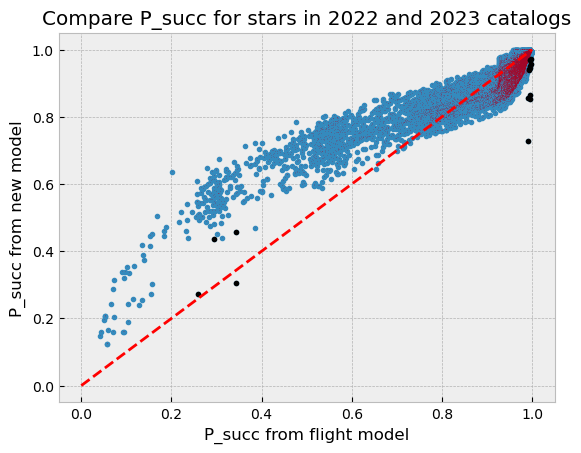

In [9]:
plt.plot(p_floors, p_quads, '.', color='C0')
plt.plot(p_floors, p_quads, ',', color='C1', alpha=0.2)
ok = t_ccds > 0
plt.plot(p_floors[ok], p_quads[ok], '.', color='k')
plt.plot([0, 1], [0, 1], 'r--');
plt.xlabel("P_succ from flight model")
plt.ylabel("P_succ from new model")
plt.title("Compare P_succ for stars in 2022 and 2023 catalogs");


In [10]:
# Outliers are from anomaly recovery
def print_outliers(ok):
    print("mags = ", mags[ok])
    print("halfwidths = ", halfwidths[ok])
    print("t_ccds = ", t_ccds[ok])
    print("p_floors = ", p_floors[ok])
    print("p_quads = ", p_quads[ok])

In [11]:
ok = (p_floors > 0.2) & (p_quads < 0.4)
print_outliers(ok)

mags =  [9.67693  9.759853]
halfwidths =  [60 60]
t_ccds =  [4.12305906 4.12305906]
p_floors =  [0.34297306 0.25780683]
p_quads =  [0.30389784 0.27247093]


In [12]:
ok = (p_floors > 0.98) & (p_quads < 0.9) & (t_ccds > 0.5)
print_outliers(ok)

mags =  [7.746064  7.7766495 8.073527  8.073527 ]
halfwidths =  [60 60 60 60]
t_ccds =  [4.12305906 4.12305906 4.12305906 0.59003293]
p_floors =  [0.99577896 0.99572799 0.99115953 0.99115953]
p_quads =  [0.86480024 0.85235544 0.72834288 0.8569362 ]


In [13]:
def reselect_catalog(aca):
    kwargs = aca.call_args.copy()
    kwargs["include_ids_acq"] = list(aca.acqs['id'])
    kwargs["include_halfws_acq"] = list(aca.acqs['halfw'])
    kwargs["dark_date"] = aca.dark_date
    kwargs["n_acq"] = len(aca.acqs)

    star_probs.DEFAULT_MODEL = 'grid-floor-2020-02'
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        aca_orig = get_aca_catalog(**kwargs)
    p2_orig = -aca_orig.acqs.get_log_p_2_or_fewer()

    star_probs.DEFAULT_MODEL = 'grid-local-quadratic-2023-05'
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        aca_new = get_aca_catalog(**kwargs)
    p2_new = -aca_new.acqs.get_log_p_2_or_fewer()

    return p2_orig, p2_new

In [14]:
p2s_orig = []
p2s_new = []

for aca_pkl in acas_pkl.values():
    p2_pkl = -aca_pkl.acqs.get_log_p_2_or_fewer()
    if p2_pkl < 4.0:
        p2_orig, p2_new = reselect_catalog(aca_pkl)
        p2s_orig.append(p2_orig)
        p2s_new.append(p2_new)

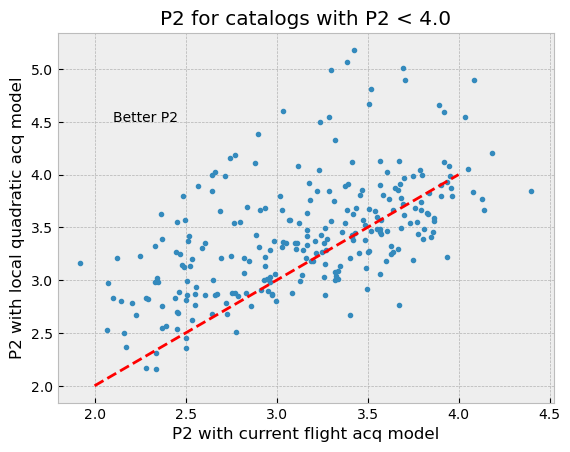

In [15]:
plt.plot(p2s_orig, p2s_new, '.', color='C0');
plt.plot([2, 4], [2, 4], 'r--');
plt.xlabel("P2 with current flight acq model")
plt.ylabel("P2 with local quadratic acq model")
plt.title("P2 for catalogs with P2 < 4.0");
plt.text(2.1, 4.5, "Better P2");

In [16]:
t_ccds, mags, halfwidths = np.meshgrid(np.arange(-12, -5.9, 1.0), np.arange(6, 10.76, 0.25), np.arange(60.0, 161, 20))

In [17]:
probs_quad = star_probs.acq_success_prob(mag=mags, t_ccd=t_ccds, halfwidth=halfwidths, model='grid-local-quadratic-2023-05').flatten()

In [18]:
probs_floor = star_probs.acq_success_prob(mag=mags, t_ccd=t_ccds, halfwidth=halfwidths, model='grid-floor-2020-02').flatten()

Text(0, 0.5, 'P_succ with new acq model')

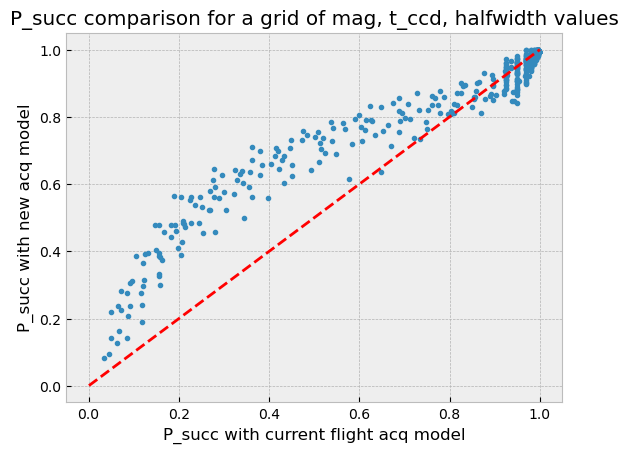

In [19]:
plt.plot(probs_floor, probs_quad, '.', color='C0');
plt.plot([1e-3, 1], [1e-3, 1], 'r--');
plt.title("P_succ comparison for a grid of mag, t_ccd, halfwidth values")
plt.xlabel("P_succ with current flight acq model")
plt.ylabel("P_succ with new acq model")

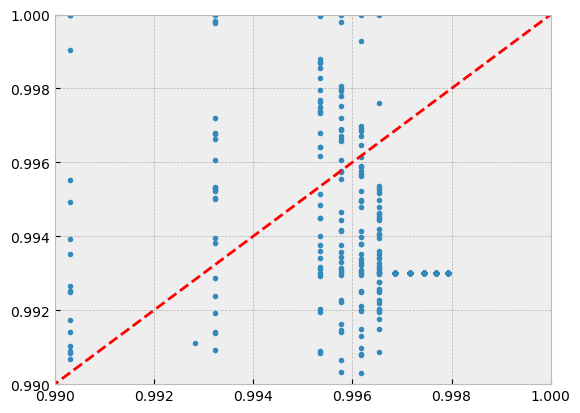

In [21]:
plt.plot(probs_floor, probs_quad, '.', color='C0');
plt.plot([1e-3, 1], [1e-3, 1], 'r--');
plt.xlim(0.99, 1)
plt.ylim(0.99, 1);